In [19]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow as pa
import os
import dask.dataframe as dd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns
from dask import dataframe as dd
from matplotlib.ticker import FuncFormatter
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import StandardScaler, LabelEncoder

# Configurações de memória
os.environ['ARROW_DEFAULT_MEMORY_POOL'] = 'system'  # Usar memória do sistema

In [10]:
ddf = dd.read_parquet(
    'C:/Users/AU355EE/OneDrive - EY/Panorama Inadimplência - Projeto Academy/Database/Database BCB/Ouro/Consolidado/consolidado_2020_a_2024.parquet')

# Visualizar esquema sem carregar tudo
print(ddf.head(0))  # Mostra apenas a estrutura

Empty DataFrame
Columns: [data_base, uf, cliente, ocupacao, cnae_secao, porte, modalidade, numero_de_operacoes, a_vencer_ate_90_dias, carteira_ativa, carteira_inadimplida_arrastada, ativo_problematico, tipo_cliente]
Index: []


In [4]:
import pyarrow.parquet as pq

# Verificar o esquema sem carregar os dados
file_path = 'C:/Users/AU355EE/OneDrive - EY/Panorama Inadimplência - Projeto Academy/Database/Database BCB/Ouro/Consolidado/consolidado_2020_a_2024.parquet'
schema = pq.read_schema(file_path)
print("Colunas disponíveis:")
print(schema.names)

Colunas disponíveis:
['data_base', 'uf', 'cliente', 'ocupacao', 'cnae_secao', 'porte', 'modalidade', 'numero_de_operacoes', 'a_vencer_ate_90_dias', 'carteira_ativa', 'carteira_inadimplida_arrastada', 'ativo_problematico', 'tipo_cliente']



Análise por Porte do Cliente:
                                              target_inadimplencia  \
                                                              mean   
porte                                                                
PF - Acima de 20 salários mínimos                         0.402259   
PF - Até 1 salário mínimo                                 0.619394   
PF - Indisponível                                         0.550933   
PF - Mais de 1 a 2 salários mínimos                       0.624353   
PF - Mais de 10 a 20 salários mínimos                     0.466194   
PF - Mais de 2 a 3 salários mínimos                       0.595611   
PF - Mais de 3 a 5 salários mínimos                       0.567814   
PF - Mais de 5 a 10 salários mínimos                      0.527579   
PF - Sem rendimento                                       0.509778   
PJ - Micro                                                0.274276   
PJ - Grande                                               0

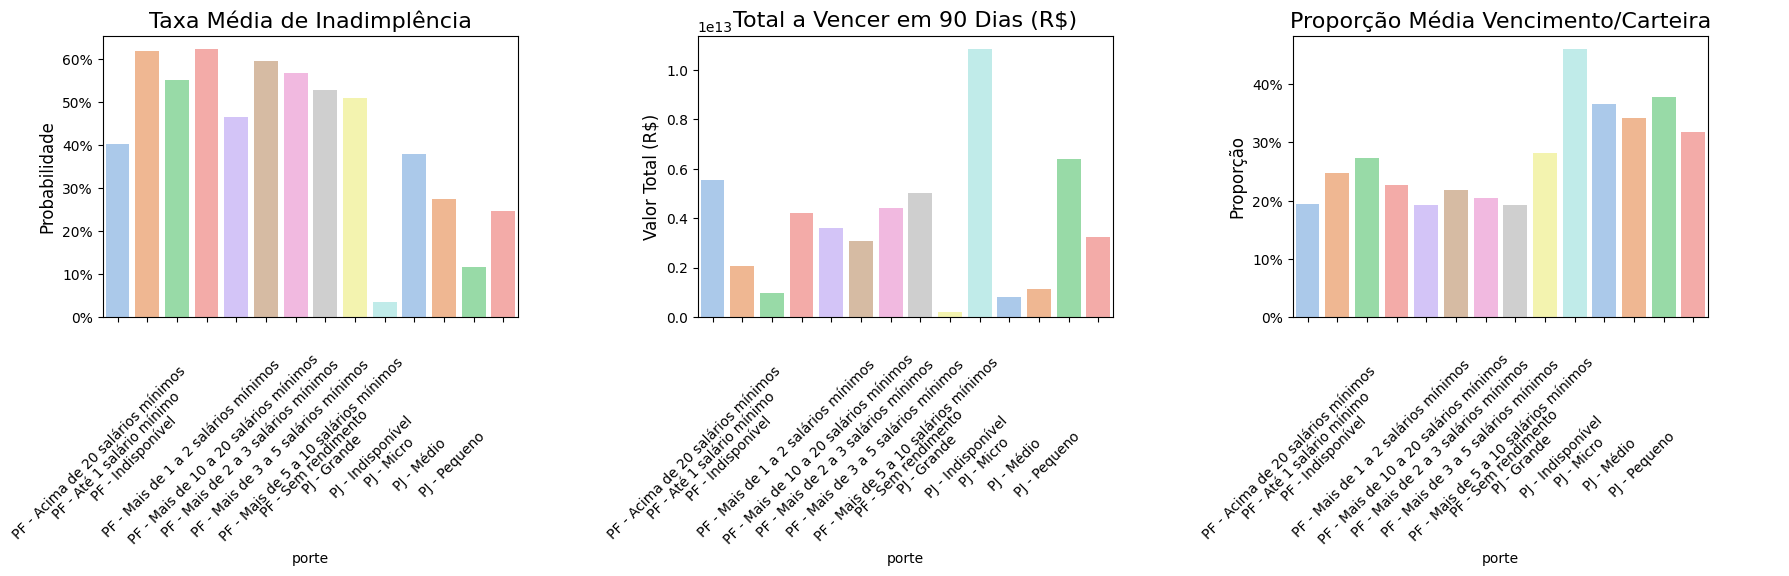

In [20]:

# 2. Pré-processamento
# Converter para categorias (reduz memória)
ddf['porte'] = ddf['porte'].astype('category')
ddf['modalidade'] = ddf['modalidade'].astype('category')

# Criar variável target (inadimplência > 0)
ddf['target_inadimplencia'] = (ddf['carteira_inadimplida_arrastada'] > 0).astype('int8')

# Criar feature de proporção
ddf['proporcao_vencer'] = ddf['a_vencer_ate_90_dias'] / ddf['carteira_ativa']

# 3. Análise por Porte
analise_porte = ddf.groupby('porte').agg({
    'target_inadimplencia': 'mean',
    'a_vencer_ate_90_dias': ['sum', 'mean', 'std'],
    'proporcao_vencer': 'mean'
}).compute()

print("\nAnálise por Porte do Cliente:")
print(analise_porte)

# Função para formatar o eixo y como porcentagem
def to_percent(y, _):
    return f'{y * 100:.0f}%'

# 4. Visualização
plt.figure(figsize=(18, 6))

# Gráfico 1: Taxa de inadimplência por porte
plt.subplot(1, 3, 1)
sns.barplot(data=analise_porte.reset_index(),
            x='porte',
            y=('target_inadimplencia', 'mean'),
            palette='pastel')  # Usar uma paleta de cores mais suave
plt.title('Taxa Média de Inadimplência', fontsize=16)
plt.ylabel('Probabilidade', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))  # Formatar y como porcentagem

# Gráfico 2: Valores a vencer por porte
plt.subplot(1, 3, 2)
sns.barplot(data=analise_porte.reset_index(),
            x='porte',
            y=('a_vencer_ate_90_dias', 'sum'),
            palette='pastel')
plt.title('Total a Vencer em 90 Dias (R$)', fontsize=16)
plt.ylabel('Valor Total (R$)', fontsize=12)
plt.xticks(rotation=45, fontsize=10)

# Gráfico 3: Proporção média
plt.subplot(1, 3, 3)
sns.barplot(data=analise_porte.reset_index(),
            x='porte',
            y=('proporcao_vencer', 'mean'),
            palette='pastel')
plt.title('Proporção Média Vencimento/Carteira', fontsize=16)
plt.ylabel('Proporção', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))  # Formatar y como porcentagem

plt.tight_layout()
plt.show()
# 6. Exportar resultados
analise_porte.to_csv('analise_inadimplencia_por_porte.csv', index=True)

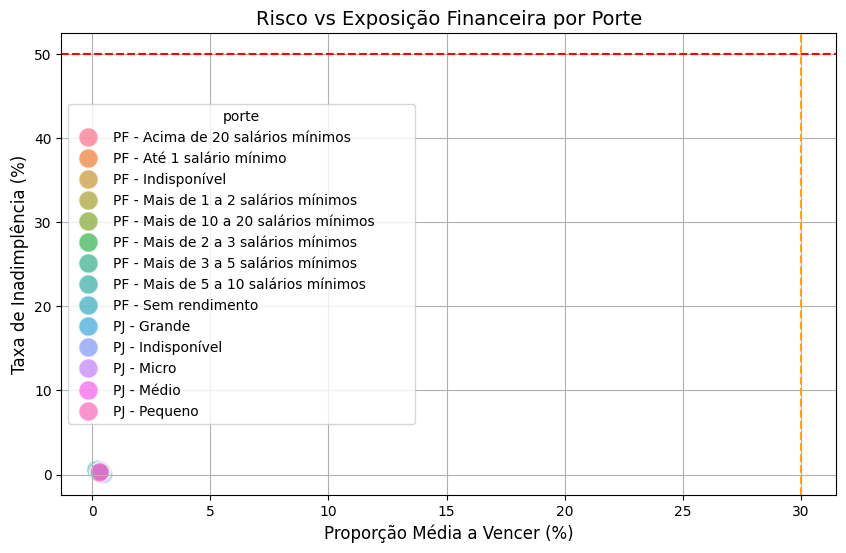

In [16]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    data=analise_porte.reset_index(),
    x=('proporcao_vencer', 'mean'),
    y=('target_inadimplencia', 'mean'),
    hue='porte',
    s=200,
    alpha=0.7
)
plt.title('Risco vs Exposição Financeira por Porte', fontsize=14)
plt.xlabel('Proporção Média a Vencer (%)', fontsize=12)
plt.ylabel('Taxa de Inadimplência (%)', fontsize=12)
plt.axhline(y=50, color='red', linestyle='--')
plt.axvline(x=30, color='orange', linestyle='--')
plt.grid(True)
plt.show()

In [21]:
from sklearn.linear_model import LinearRegression

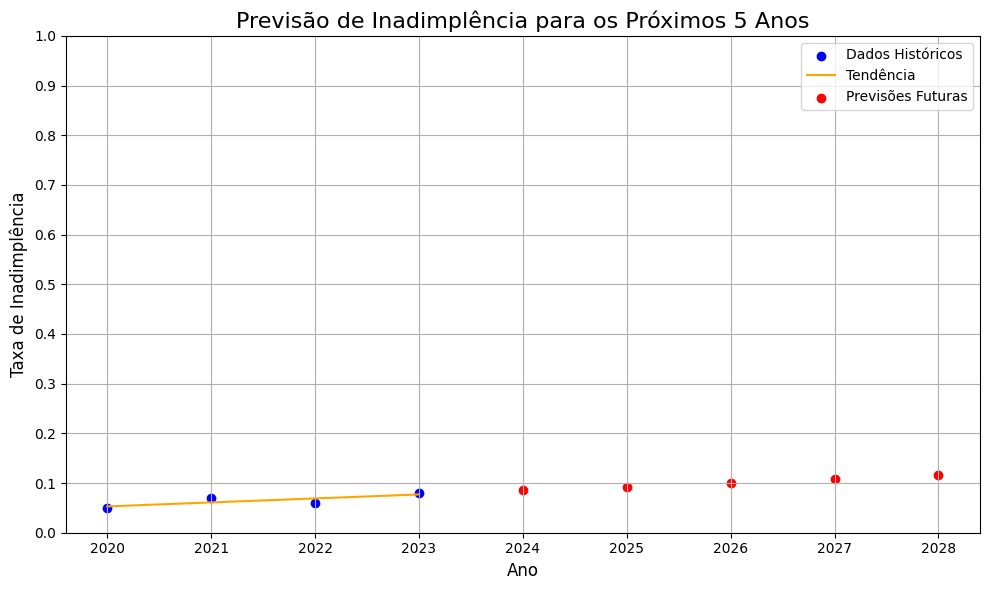

Previsão de inadimplência para 2024: 8.50%
Previsão de inadimplência para 2025: 9.30%
Previsão de inadimplência para 2026: 10.10%
Previsão de inadimplência para 2027: 10.90%
Previsão de inadimplência para 2028: 11.70%


In [22]:
# Exemplo de dados: anos e taxa de inadimplência média
anos = np.array([2020, 2021, 2022, 2023])  # Anos históricos
inadimplencia = np.array([0.05, 0.07, 0.06, 0.08])  # Taxa de inadimplência média correspondente

# Criar DataFrame
df = pd.DataFrame({'Ano': anos, 'Inadimplencia': inadimplencia})

# Ajustar o modelo de regressão linear
X = df['Ano'].values.reshape(-1, 1)  # Reshape para o modelo
y = df['Inadimplencia'].values
model = LinearRegression()
model.fit(X, y)

# Prever para os próximos 5 anos
anos_futuros = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
previsoes = model.predict(anos_futuros)

# Plotar os dados históricos e as previsões
plt.figure(figsize=(10, 6))
plt.scatter(df['Ano'], df['Inadimplencia'], color='blue', label='Dados Históricos')
plt.plot(df['Ano'], model.predict(X), color='orange', label='Tendência')
plt.scatter(anos_futuros, previsoes, color='red', label='Previsões Futuras')
plt.title('Previsão de Inadimplência para os Próximos 5 Anos', fontsize=16)
plt.xlabel('Ano', fontsize=12)
plt.ylabel('Taxa de Inadimplência', fontsize=12)
plt.xticks(np.arange(2020, 2029, 1))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Exibir previsões
for ano, previsao in zip(anos_futuros.flatten(), previsoes):
    print(f'Previsão de inadimplência para {ano}: {previsao:.2%}')